In [1]:
# Import all libraries needed for this notebook
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import re
from Bio import AlignIO
import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
import matplotlib.pyplot as plt

# Convert .a3m to .fasta
# Preprocess the a3m file to remove insertions (lowercase letters)
def preprocess_a3m(a3m_file, processed_file):
    with open(a3m_file, "r") as infile, open(processed_file, "w") as outfile:
        for record in SeqIO.parse(infile, "fasta"):
            sequence = str(record.seq)
            processed_sequence = re.sub(r'[a-z]', '', sequence)
            record.seq = processed_sequence
            SeqIO.write(record, outfile, "fasta")

# Convert the A3M file to FASTA format after preprocessing
def convert_a3m_to_fasta(a3m_file, fasta_file):
    preprocessed_file = "preprocessed_a3m.fasta"
    preprocess_a3m(a3m_file, preprocessed_file)
    
    # Read the preprocessed file and write to the final FASTA file
    alignment = list(SeqIO.parse(preprocessed_file, "fasta"))
    SeqIO.write(alignment, fasta_file, "fasta")
    
convert_a3m_to_fasta("ube2i_msa.a3m", "ube2i_msa.fasta")

/Users/julijamaldutyte/anaconda3/lib/python3.11/site-packages/Bio/SeqRecord.py:355: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


In [2]:
# Function to read MSA from FASTA file and convert to a frequency matrix
def read_msa(msa_file):
    alignment = AlignIO.read(msa_file, "fasta")
    num_sequences = len(alignment)
    sequence_length = alignment.get_alignment_length()
    amino_acids = "ARNDCQEGHILKMFPSTWYV"
    aa_index = {aa: i for i, aa in enumerate(amino_acids)}
    
    frequency_matrix = np.zeros((sequence_length, len(amino_acids)))
    
    for record in alignment:
        for i, aa in enumerate(record.seq):
            if aa in aa_index:
                frequency_matrix[i, aa_index[aa]] += 1
    
    frequency_matrix /= num_sequences
    return frequency_matrix, amino_acids

# Function to calculate the PSSM (position-specific scoring matrix) from the frequency matrix with pseudocounts
def calculate_pssm(frequency_matrix, background_freq=None, pseudocount=1e-6):
    if background_freq is None:
        background_freq = np.ones(frequency_matrix.shape[1]) / frequency_matrix.shape[1]
    
    # Add pseudocounts to avoid log(0)
    frequency_matrix += pseudocount
    
    pssm = np.log(frequency_matrix / background_freq)
    return pssm

In [3]:
# Function to generate PSSM for a mutant sequence
def get_mutant_pssm_features(wild_type_sequence, mutant_sequence, pssm, amino_acids):
    aa_index = {aa: i for i, aa in enumerate(amino_acids)}
    mutant_pssm = pssm.copy()
    for i, (wt_aa, mut_aa) in enumerate(zip(wild_type_sequence, mutant_sequence)):
        if wt_aa != mut_aa and mut_aa in aa_index:
            mut_aa_index = aa_index[mut_aa]
            mutant_pssm[i] = np.zeros(len(amino_acids))  # Reset to zero
            mutant_pssm[i, mut_aa_index] = pssm[i, mut_aa_index]
    return mutant_pssm.flatten()

In [4]:
# Read MSA and calculate frequency matrix
msa_file = "ube2i_msa.fasta"
frequency_matrix, amino_acids = read_msa(msa_file)

In [5]:
# Calculate background frequencies
background_freq = np.ones(len(amino_acids)) / len(amino_acids)

# Calculate PSSM
pssm = calculate_pssm(frequency_matrix, background_freq)

# Print the PSSM
print("PSSM:")
print(pssm)
print("Shape of PSSM:", pssm.shape)

PSSM:
[[ -1.67125401  -3.56130343  -3.46899225 ...  -5.38219767  -5.52462951
   -3.08353526]
 [ -0.45685934  -2.8060094   -1.94386486 ...  -5.60425432  -3.34045237
   -2.66497433]
 [ -0.83755843  -2.250873    -1.01621052 ...  -5.8901275   -4.62682558
   -2.5768913 ]
 ...
 [  1.63089316  -2.60127626  -3.66301068 ...  -6.13937862  -5.09560369
   -3.25780547]
 [ -1.70930245  -3.08353526  -3.44002306 ...  -6.4721476   -6.4721476
   -4.45529808]
 [ -4.3553786   -4.72505425  -5.1467251  ... -10.81977828  -8.03113034
   -6.4721476 ]]
Shape of PSSM: (158, 20)


In [6]:
# Read mutant sequences
mutant_fasta_file = "ube2i_single_point_mutants.fasta"  
mutant_sequences = list(SeqIO.parse(mutant_fasta_file, "fasta"))

# Wild-type sequence (the first sequence in the MSA)
wild_type_sequence = str(AlignIO.read(msa_file, "fasta")[0].seq)

In [7]:
# Generate PSSMs for all mutants and save them
pssm_features = {}
for mutant in mutant_sequences:
    mutant_sequence = str(mutant.seq)
    features = get_mutant_pssm_features(wild_type_sequence, mutant_sequence, pssm, amino_acids)
    pssm_features[mutant.id] = features

In [8]:
for key in pssm_features.keys():
    print(f"Array '{key}' has shape: {pssm_features[key].shape}")

Array 'K30D:0.5080366134643555' has shape: (3160,)
Array 'D127S:0.619499683380127' has shape: (3160,)
Array 'L114Y:0.9718983173370361' has shape: (3160,)
Array 'H83F:0.5161952972412109' has shape: (3160,)
Array 'R61G:0.7325457334518433' has shape: (3160,)
Array 'A156D:1.3797361850738525' has shape: (3160,)
Array 'W16D:0.30818527936935425' has shape: (3160,)
Array 'C75P:1.3841304779052734' has shape: (3160,)
Array 'Y68S:0.44405993819236755' has shape: (3160,)
Array 'K49N:1.1037579774856567' has shape: (3160,)
Array 'I116Q:0.528228223323822' has shape: (3160,)
Array 'P46T:0.5449302792549133' has shape: (3160,)
Array 'R17W:0.4271722137928009' has shape: (3160,)
Array 'V25G:0.5126227736473083' has shape: (3160,)
Array 'R149K:0.9444552659988403' has shape: (3160,)
Array 'K76T:1.3542524576187134' has shape: (3160,)
Array 'N37L:0.7731716632843018' has shape: (3160,)
Array 'N140G:0.39711204171180725' has shape: (3160,)
Array 'Y87L:0.3865112364292145' has shape: (3160,)
Array 'P88R:1.2692936658

In [9]:
# Convert the dictionary to a data frame
mutant_pssm = pd.DataFrame.from_dict(pssm_features, orient='index')

# Add column names
num_features = mutant_pssm.shape[1]
mutant_pssm.columns = [f"feature_{i+1}" for i in range(num_features)]

# Reset the index to convert the index into a column
mutant_pssm.reset_index(inplace=True)

# Rename the index column to 'id'
mutant_pssm.rename(columns={'index': 'id'}, inplace=True)

print(mutant_pssm.head())

                         id  feature_1  feature_2  feature_3  feature_4  \
0   K30D:0.5080366134643555  -1.671254  -3.561303  -3.468992  -4.429367   
1   D127S:0.619499683380127  -1.671254  -3.561303  -3.468992  -4.429367   
2  L114Y:0.9718983173370361  -1.671254  -3.561303  -3.468992  -4.429367   
3   H83F:0.5161952972412109  -1.671254  -3.561303  -3.468992  -4.429367   
4   R61G:0.7325457334518433  -1.671254  -3.561303  -3.468992  -4.429367   

   feature_5  feature_6  feature_7  feature_8  feature_9  ...  feature_3151  \
0  -4.873114  -3.711762  -4.455298  -2.982225  -4.796346  ...     -5.890127   
1  -4.873114  -3.711762  -4.455298  -2.982225  -4.796346  ...     -5.890127   
2  -4.873114  -3.711762  -4.455298  -2.982225  -4.796346  ...     -5.890127   
3  -4.873114  -3.711762  -4.455298  -2.982225  -4.796346  ...     -5.890127   
4  -4.873114  -3.711762  -4.455298  -2.982225  -4.796346  ...     -5.890127   

   feature_3152  feature_3153  feature_3154  feature_3155  feature_3156  \

In [10]:
### To see how much info PSSM contributes, import features.csv, use fitness score from there as target and train on PSSM marix only
# Import features.csv

features = pd.read_csv("features.csv")
features[['mut_id', 'fitness']] = features['id'].str.split(':', expand=True)
features = features[['id', 'mut_id', 'fitness'] + [col for col in features.columns if col not in ['id', 'mut_id', 'fitness']]]
features['fitness'] = pd.to_numeric(features['fitness'])

# Bin fitness scores by quantiles
quantile_no = 8
features['fitness_group'], bins = pd.qcut(features['fitness'], q=quantile_no, labels=False, retbins=True)

# Print bin edges
print("Bin edges (boundaries):", bins)
features_meta = features[['id', 'fitness', 'fitness_group']]
#display(features_meta)

# Merge some features columns with the mutant_pssm
mutant_pssm_fitness = pd.merge(features_meta, mutant_pssm, on='id')
display(mutant_pssm_fitness)

Bin edges (boundaries): [0.         0.34742916 0.41501102 0.49650659 0.62802055 0.77240558
 0.9084807  1.10469232 4.10751009]


,id,fitness,fitness_group,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_3151,feature_3152,feature_3153,feature_3154,feature_3155,feature_3156,feature_3157,feature_3158,feature_3159,feature_3160
0,K30D:0.5080366134643555,0.508037,3,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
1,D127S:0.619499683380127,0.619500,3,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
2,L114Y:0.9718983173370361,0.971898,6,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
3,H83F:0.5161952972412109,0.516195,3,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
4,R61G:0.7325457334518433,0.732546,4,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,A15W:0.6964787244796753,0.696479,4,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
2850,P28F:0.5048689246177673,0.504869,3,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
2851,I112Y:0.28946661949157715,0.289467,0,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
2852,P32W:0.9419150352478027,0.941915,6,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148


In [11]:
# Train an rfr
# Split the data into features (X) and target (y)
X = mutant_pssm_fitness.drop(columns=['fitness'])
y = mutant_pssm_fitness['fitness']

# Use train_test_split with the stratify parameter
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=96, stratify=X['fitness_group'], random_state=42)

display(X_train)

# Train the rfr
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train.drop(columns=['id', 'fitness_group']), y_train)

# Predict the fitness scores for the test set
y_pred = rfr.predict(X_test.drop(columns=['id', 'fitness_group']))

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2}")
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Spearman's correl
spearman_corr, spearman_p_value = spearmanr(y_test, y_pred)
print(f"Spearman's correlation: {spearman_corr}")
print(f"Spearman's p-value: {spearman_p_value}")

,id,fitness_group,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_3151,feature_3152,feature_3153,feature_3154,feature_3155,feature_3156,feature_3157,feature_3158,feature_3159,feature_3160
743,F77S:0.34993505477905273,1,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,-2.982225,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
1451,P73N:0.37244078516960144,1,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,-2.982225,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
2247,L57Q:0.9007079005241394,5,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,-2.982225,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
2281,D102W:0.8114498257637024,5,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,-2.982225,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
544,T29G:0.9752710461616516,6,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,-2.982225,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,F77H:0.3387545049190521,0,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,-2.982225,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
2500,L94N:0.44525304436683655,2,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,-2.982225,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
480,L38F:0.8292379379272461,5,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,-2.982225,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148
1174,A156F:0.8652383685112,5,-1.671254,-3.561303,-3.468992,-4.429367,-4.873114,-3.711762,-4.455298,-2.982225,...,-5.890127,-4.796346,-8.03113,-7.369218,-6.139379,-2.630498,-5.52463,-10.819778,-8.03113,-6.472148


Mean Squared Error: 0.15073790199907663
R2 score: -0.19556807374214036
Mean Absolute Error: 0.2711242831580576
Spearman's correlation: 0.28143331396763577
Spearman's p-value: 2.224900093406546e-51


Best alpha: 1000.0
Training Score: 0.706473494076256
Test Score: 0.07754762165467843
Mean Squared Error: 0.11630331995283957
R2 score: 0.07754762165467843
Mean Absolute Error: 0.2569082361193148
Spearman's correlation: 0.3499756209869372
Spearman's p-value: 2.7719082640432305e-80


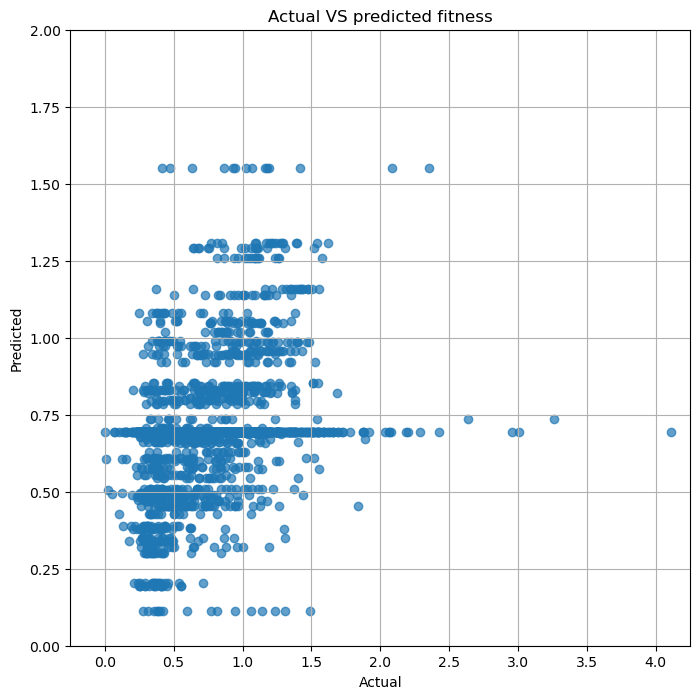

In [12]:
### Ridge regression 

# Scale data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train.drop(columns=['id', 'fitness_group']))
X_test_norm = scaler.fit_transform(X_test.drop(columns=['id', 'fitness_group']))

alphas = np.logspace(-6, 6, 13)  # Define a range of alphas for cross-validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train_norm, y_train)

# Predict the fitness for the test set
y_pred_ridge = ridge_cv.predict(X_test_norm)

# Print the best alpha and model performance
print(f"Best alpha: {ridge_cv.alpha_}")
print(f"Training Score: {ridge_cv.score(X_train_norm, y_train)}")
print(f"Test Score: {ridge_cv.score(X_test_norm, y_test)}")

# Predict and evaluate the model
mse = mean_squared_error(y_test, y_pred_ridge)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred_ridge)
print(f"R2 score: {r2}")
mae = mean_absolute_error(y_test, y_pred_ridge)
print(f"Mean Absolute Error: {mae}")
# Spearman's correl
spearman_corr, spearman_p_value = spearmanr(y_test, y_pred_ridge)
print(f"Spearman's correlation: {spearman_corr}")
print(f"Spearman's p-value: {spearman_p_value}")

# Plot actual fitness against predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_ridge, alpha=0.7)
plt.xlim(-0.25, 4.25)
plt.ylim(0, 2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual VS predicted fitness')
plt.grid(True)
plt.show()

In [13]:
### Calculate the mean of the 3160 features for each sample and use that for model training###
# Select features1-3160
features_df = mutant_pssm_fitness.iloc[:, 3:] # the original MSA PSSM feature df with fitness scores and IDs

# Calculate the mean across the selected columns for each row
mean_pssm = features_df.mean(axis=1)

# Add back id, fitness, fitness group
mean_pssm_fitness = pd.DataFrame({
    'id': mutant_pssm_fitness.iloc[:, 0],
    'fitness': mutant_pssm_fitness.iloc[:, 1],
    'fitness_group': mutant_pssm_fitness.iloc[:, 2],
    'mean_pssm': mean_pssm
})

display(mean_pssm_fitness)

,id,fitness,fitness_group,mean_pssm
0,K30D:0.5080366134643555,0.508037,3,-2.092548
1,D127S:0.619499683380127,0.619500,3,-2.090103
2,L114Y:0.9718983173370361,0.971898,6,-2.095258
3,H83F:0.5161952972412109,0.516195,3,-2.085923
4,R61G:0.7325457334518433,0.732546,4,-2.097639
...,...,...,...,...
2849,A15W:0.6964787244796753,0.696479,4,-2.096031
2850,P28F:0.5048689246177673,0.504869,3,-2.091682
2851,I112Y:0.28946661949157715,0.289467,0,-2.086953
2852,P32W:0.9419150352478027,0.941915,6,-2.091496


In [14]:
mean_pssm_fitness.to_csv('mean_pssm_fitness.csv', index=False)

Best alpha: 10.0
Training Score: 0.08021350581764519
Test Score: 0.07476341145855736
Mean Squared Error: 0.11665435475621476
R2 score: 0.07476341145855736
Mean Absolute Error: 0.26252787407027584
Spearman's correlation: 0.33303079326303414
Spearman's p-value: 2.020987099978103e-72


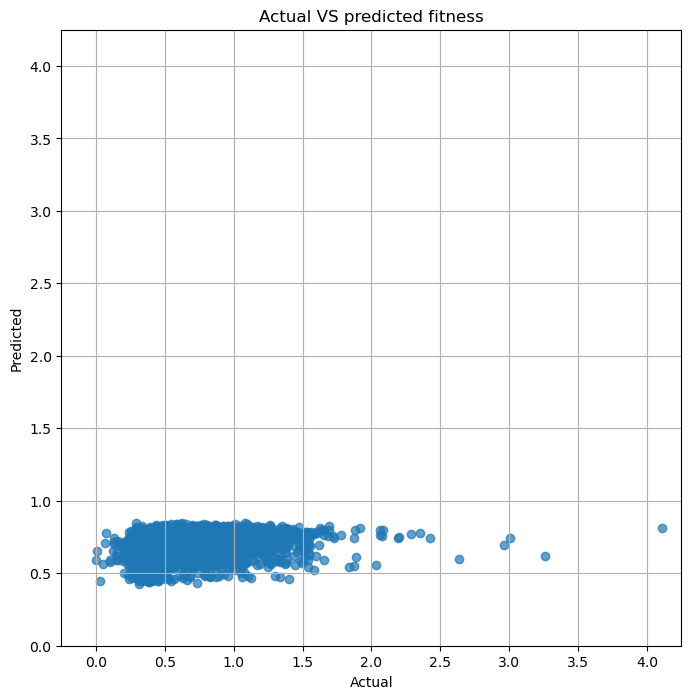

In [15]:
# Ridge regr on a single mean of features

# Use train_test_split with the stratify parameter
X1 = mean_pssm_fitness.drop(columns=['fitness'])
y1 = mean_pssm_fitness['fitness']

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, train_size=96, stratify=X1['fitness_group'], random_state=42)

scaler = StandardScaler()
X_train1_norm = scaler.fit_transform(X_train1.drop(columns=['id', 'fitness_group']))
X_test1_norm = scaler.fit_transform(X_test1.drop(columns=['id', 'fitness_group']))

alphas = np.logspace(-6, 6, 13)  # Define a range of alphas for cross-validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train1_norm, y_train1)

# Predict the fitness for the test set
y_pred_ridge1 = ridge_cv.predict(X_test1_norm)

# Print the best alpha and model performance
print(f"Best alpha: {ridge_cv.alpha_}")
print(f"Training Score: {ridge_cv.score(X_train1_norm, y_train1)}")
print(f"Test Score: {ridge_cv.score(X_test1_norm, y_test1)}")

# Predict and evaluate the model
mse = mean_squared_error(y_test1, y_pred_ridge1)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test1, y_pred_ridge1)
print(f"R2 score: {r2}")
mae = mean_absolute_error(y_test1, y_pred_ridge1)
print(f"Mean Absolute Error: {mae}")
# Spearman's correl
spearman_corr, spearman_p_value = spearmanr(y_test1, y_pred_ridge1)
print(f"Spearman's correlation: {spearman_corr}")
print(f"Spearman's p-value: {spearman_p_value}")

# Plot actual fitness against predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test1, y_pred_ridge1, alpha=0.7)
plt.xlim(-0.25, 4.25)
plt.ylim(0, 4.25)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual VS predicted fitness')
plt.grid(True)
plt.show()

### Considering the amount of features reduced, Spearman correlation barely dropped. Use only the mean of the PSSM matrix for further model training

In [16]:
# Merge with biophysical features and using mean_pssm and top 11 biophysical features selected previously, run RFR and RR
features = pd.read_csv("features.csv")
features[['mut_id', 'fitness']] = features['id'].str.split(':', expand=True)
features = features[['id', 'mut_id', 'fitness'] + [col for col in features.columns if col not in ['id', 'mut_id', 'fitness']]]
features['fitness'] = pd.to_numeric(features['fitness'])

# Merge with features_top on 'fitness'
features_pssm = pd.merge(features, mean_pssm_fitness, on='id', how='inner')
# Drop duplicates (checked to make sure it's the same) and rename _x to original
features_pssm = features_pssm.drop(columns=['fitness_y'])
features_pssm = features_pssm.rename(columns={'fitness_x': 'fitness'})
display(features_pssm)

,id,mut_id,fitness,Volume,MolWt,NumHeavyAtoms,Hydropathy,NumRotatableBonds,FractionCSP3,Acceptor,...,NumPolarRes,NumApolarRes,NumChargedRes,ProtRDF_all_2.0_3.0,ProtRDF_all_3.0_4.0,ProtRDF_all_4.0_5.0,RosettaEnergy,loss,fitness_group,mean_pssm
0,K30D:0.5080366134643555,K30D,0.508037,-57.5,-13.087,-1,0.4,-2,-0.333333,2,...,6,9,3,1,-11,-20,-11.954,0.181988,3,-2.092548
1,D127S:0.619499683380127,D127S,0.619500,-22.1,-28.010,-2,2.7,-1,0.166667,-1,...,13,14,5,-1,-12,8,-1.321,0.117051,3,-2.090103
2,L114Y:0.9718983173370361,L114Y,0.971898,26.9,50.016,4,-5.1,0,-0.611111,1,...,10,29,7,-5,-16,-51,3.378,0.172539,6,-2.095258
3,H83F:0.5161952972412109,H83F,0.516195,36.7,10.035,1,6.0,0,-0.111111,-1,...,19,31,12,8,24,48,33.264,0.211969,3,-2.085923
4,R61G:0.7325457334518433,R61G,0.732546,-113.3,-99.137,-7,4.1,-4,-0.166667,-1,...,9,32,7,-21,-72,-171,-6.110,0.151326,4,-2.097639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,A15W:0.6964787244796753,A15W,0.696479,139.2,115.135,9,-2.7,2,-0.484848,0,...,8,13,8,9,67,168,-13.282,0.207076,4,-2.096031
2850,P28F:0.5048689246177673,P28F,0.504869,77.2,50.060,4,4.4,2,-0.577778,0,...,11,20,8,-1,13,55,-6.672,0.173218,3,-2.091682
2851,I112Y:0.28946661949157715,I112Y,0.289467,26.9,50.016,4,-5.8,0,-0.611111,1,...,14,31,11,17,21,6,111.471,0.174368,0,-2.086953
2852,P32W:0.9419150352478027,P32W,0.941915,115.1,89.097,7,0.7,2,-0.618182,0,...,5,4,3,-8,23,56,-13.450,0.201536,6,-2.091496


Best alpha: 100.0
Training Score: 0.3461378843468901
Test Score: 0.125008847315787
Mean Squared Error: 0.11031938165640487
R2 score: 0.125008847315787
Mean Absolute Error: 0.24858404509240656
Spearman's correlation: 0.4247192174234317
Spearman's p-value: 3.20888206257661e-121


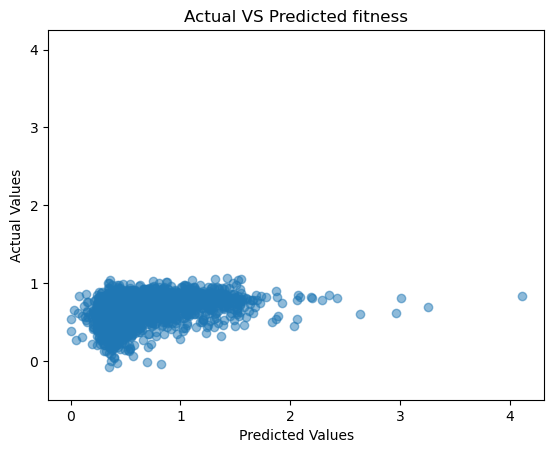

In [17]:
# Drop bottom features as determined by RFR
X = features_pssm.drop(columns=['mut_id', 'fitness', 'loss', 'Aromatic', 'NetCharge', 'LumpedHydrophobe', 'Donor', 'NumHeavyAtoms', 'Acceptor', 'NumChargedRes', 'Hydrophobe', 'ProtRDF_all_4.0_5.0']) #Still contains 'id' and 'fitness_group'columns
y = features_pssm['fitness']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X.drop(columns=['id', 'fitness_group']))

# Scale
minmaxscaler = MinMaxScaler()
scaler = StandardScaler()
X_poly_norm = scaler.fit_transform(X_poly)
X_poly_minmax = minmaxscaler.fit_transform(X_poly)

# Sample 96 samples, in a stratified manner, based on fitness_group
X_train, X_test, y_train, y_test = train_test_split(X_poly_norm, y, train_size=96, stratify=X['fitness_group'], random_state=42)

# Define a range of alphas for cross-validation
alphas = np.logspace(-6, 6, 13)  
ridge_cv_poly = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv_poly.fit(X_train, y_train)

# Predict the fitness for the test set
y_pred_ridge_poly = ridge_cv_poly.predict(X_test)

# Print the best alpha and model performance
print(f"Best alpha: {ridge_cv_poly.alpha_}")
print(f"Training Score: {ridge_cv_poly.score(X_train, y_train)}")
print(f"Test Score: {ridge_cv_poly.score(X_test, y_test)}")

# Predict and evaluate the model
mse = mean_squared_error(y_test, y_pred_ridge_poly)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred_ridge_poly)
print(f"R2 score: {r2}")
mae = mean_absolute_error(y_test, y_pred_ridge_poly)
print(f"Mean Absolute Error: {mae}")
# Spearman's correl
spearman_corr, spearman_p_value = spearmanr(y_test, y_pred_ridge_poly)
print(f"Spearman's correlation: {spearman_corr}")
print(f"Spearman's p-value: {spearman_p_value}")

# Plot predicted VS actal fitness
plt.scatter(y_test, y_pred_ridge_poly, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylim(-0.5, 4.25)
plt.ylabel('Actual Values')
plt.title('Actual VS Predicted fitness')
plt.show()

In [18]:
# RFR
# Drop bottom features as determined by RFR
X = features_pssm.drop(columns=['mut_id', 'fitness', 'loss', 'Aromatic', 'NetCharge', 'LumpedHydrophobe', 'Donor', 'NumHeavyAtoms', 'Acceptor', 'NumChargedRes', 'Hydrophobe', 'ProtRDF_all_4.0_5.0']) #Still contains 'id' and 'fitness_group'columns
y = features_pssm['fitness']

# Use train_test_split with the stratify parameter
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=96, stratify=X['fitness_group'], random_state=42)

display(X_train)

# Train the rfr
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train.drop(columns=['id', 'fitness_group']), y_train)

# Predict the fitness scores for the test set
y_pred = rfr.predict(X_test.drop(columns=['id', 'fitness_group']))

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2}")
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Spearman's correl
spearman_corr, spearman_p_value = spearmanr(y_test, y_pred)
print(f"Spearman's correlation: {spearman_corr}")
print(f"Spearman's p-value: {spearman_p_value}")

,id,Volume,MolWt,Hydropathy,NumRotatableBonds,FractionCSP3,Charge,NumPolarRes,NumApolarRes,ProtRDF_all_2.0_3.0,ProtRDF_all_3.0_4.0,RosettaEnergy,fitness_group,mean_pssm
743,F77S:0.34993505477905273,-100.9,-60.099,-3.6,-1,0.444444,1,16,37,-33,-110,-2.958,1,-2.086381
1451,P73N:0.37244078516960144,1.4,16.987,-1.9,2,-0.300000,1,13,26,5,-12,1.595,1,-2.079922
2247,L57Q:0.9007079005241394,-22.9,14.971,-7.3,1,-0.233333,4,7,29,-11,-32,-11.100,5,-2.098448
2281,D102W:0.8114498257637024,116.7,71.126,2.6,0,-0.318182,-2,9,12,3,19,-7.367,5,-2.096282
544,T29G:0.9752710461616516,-56.0,-44.053,0.3,-1,-0.250000,1,6,16,-13,-62,-11.643,6,-2.097281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,F77H:0.3387545049190521,-36.7,-10.035,-6.0,0,0.111111,1,16,37,-17,-35,-8.135,0,-2.086934
2500,L94N:0.44525304436683655,-52.6,0.944,-7.3,0,-0.333333,-2,14,27,-5,-56,-12.894,2,-2.088909
480,L38F:0.8292379379272461,23.2,34.017,-1.0,0,-0.611111,4,12,20,-7,-21,-11.468,5,-2.091405
1174,A156F:0.8652383685112,101.3,76.098,1.0,2,-0.444444,3,2,17,12,31,-9.789,5,-2.085013


Mean Squared Error: 0.10846081520528092
R2 score: 0.1397499488066758
Mean Absolute Error: 0.24571161511364958
Spearman's correlation: 0.4203249000100723
Spearman's p-value: 1.6448964363241758e-118
